<a href="https://colab.research.google.com/github/mmminji/Project/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# preprocess
from sklearn.model_selection import train_test_split 
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit

# model
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

# eval
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

# plot
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드
censor = pd.read_csv('censor.csv', encoding='CP949')
location = pd.read_csv('location.csv')

In [ ]:
censor.head()

,년,월,일,시,분,초,시간(vision 통과),계측시간,#1,#2,#3,#4,#5,#6,#7
0,20,8,21,14,52,38,14:53:23,50.7,21.888,21.409,21.116,20.966,21.138,21.632,22.361
1,20,8,21,14,52,38,14:53:23,50.7,21.874,21.395,21.101,20.953,21.122,21.616,22.350
2,20,8,21,14,52,38,14:53:23,50.7,21.847,21.368,21.076,20.934,21.111,21.604,22.337
3,20,8,21,14,52,38,14:53:23,50.7,21.839,21.354,21.056,20.905,21.080,21.564,22.293
4,20,8,21,14,52,38,14:53:23,50.7,21.819,21.338,21.044,20.898,21.076,21.562,22.292


In [ ]:
location.head()

,No,Date,Time,시간,Model,Refer_Result,Result,LOT-ID,Stage,A1U_OK/NG,...,TW_C,TS_A_OK/NG,TS_A_Result,TS_A,TS_C_OK/NG,TS_C_Result,TS_C,TH_A_OK/NG,TH_A_Result,TH_A
0,118007,20200821,145502,14:55:02,DOWN,NG,OK,LOT-ID,Rear,OK,...,44.882,OK,0,23.312,OK,0,23.301,OK,0,18.085
1,118008,20200821,145502,14:55:02,DOWN,NG,OK,LOT-ID,Front,OK,...,44.876,OK,0,23.298,OK,0,23.386,OK,0,17.984
2,118009,20200821,145504,14:55:04,DOWN,NG,OK,LOT-ID,Rear,OK,...,44.845,OK,0,23.301,OK,0,23.455,OK,0,17.894
3,118010,20200821,145504,14:55:04,DOWN,NG,OK,LOT-ID,Front,OK,...,44.950,OK,0,23.281,OK,0,23.317,OK,0,18.042
4,118011,20200821,145505,14:55:05,DOWN,NG,OK,LOT-ID,Rear,OK,...,44.884,OK,0,23.311,OK,0,23.297,OK,0,17.989


In [ ]:
# 동일한 시간일때 최대값과 최소값의 차로 데이터 구성
def censor_preprocessing(censor):
    censor_time = censor['시간(vision 통과)'].unique()
    feature = ['#1','#2','#3','#4','#5','#6','#7']
    censor_df = pd.DataFrame(columns=['시간(vision 통과)','#1','#2','#3','#4','#5','#6','#7'])
    for i in tqdm(range(len(censor_time))):
        data = censor[censor['시간(vision 통과)']==censor_time[i]]
        value = [censor_time[i]]
        for j in feature:
            value.append(data[j].max() - data[j].min())
        censor_df.loc[i] = value
    return censor_df

In [ ]:
# NG/OK로만 column 구성, 동일한 시간일때 하나라도 NG면 NG로 판정
def location_preprocessing(location):
    location_time = location['시간'].unique()
    feature = [' A1U_OK/NG',' A2U_OK/NG',' A3U_OK/NG',' A4U_OK/NG',' A5U_OK/NG',' A6U_OK/NG',
               ' TW_A_OK/NG', ' TW_C_OK/NG', ' TS_A_OK/NG', ' TS_C_OK/NG', ' TH_A_OK/NG']
    location_df = pd.DataFrame(columns=['시간(vision 통과)','A1U_OK/NG','A2U_OK/NG','A3U_OK/NG',
                                      'A4U_OK/NG','A5U_OK/NG','A6U_OK/NG', 
                                      'TW_A_OK/NG', 'TW_C_OK/NG', 'TS_A_OK/NG', 'TS_C_OK/NG', 'TH_A_OK/NG'])
    for i in tqdm(range(len(location_time))):
        data = location[location['시간']==location_time[i]]
        value = [location_time[i]]
        for j in feature:
            if ' NG' in data[j].tolist():
                value.append('NG')
            else:
                value.append('OK')
        location_df.loc[i] = value
    return location_df

In [ ]:
# 데이터 처리
censor_df = censor_preprocessing(censor)
location_df = location_preprocessing(location)

100%|██████████| 11278/11278 [01:14<00:00, 152.16it/s]


In [ ]:
censor_df.head()

,시간(vision 통과),#1,#2,#3,#4,#5,#6,#7
0,14:53:23,0.069,0.071,0.072,0.068,0.062,0.070,0.069
1,14:53:24,0.060,0.062,0.063,0.057,0.050,0.055,0.051
2,14:53:25,0.056,0.058,0.054,0.053,0.051,0.061,0.055
3,14:53:26,0.072,0.073,0.072,0.067,0.059,0.062,0.056
4,14:53:27,0.071,0.074,0.073,0.067,0.064,0.070,0.068


In [ ]:
location_df.head()

,시간(vision 통과),A1U_OK/NG,A2U_OK/NG,A3U_OK/NG,A4U_OK/NG,A5U_OK/NG,A6U_OK/NG,TW_A_OK/NG,TW_C_OK/NG,TS_A_OK/NG,TS_C_OK/NG,TH_A_OK/NG
0,14:55:02,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
1,14:55:04,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
2,14:55:05,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
3,14:55:06,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
4,14:55:07,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK


In [ ]:
# 데이터 병합 & 저장
df = pd.merge(censor_df,location_df)
df.to_csv('merge_df.csv', encoding='utf-8-sig', index=False)

In [2]:
df = pd.read_csv('merge_df.csv')

In [3]:
df

,시간(vision 통과),#1,#2,#3,#4,#5,#6,#7,A1U_OK/NG,A2U_OK/NG,A3U_OK/NG,A4U_OK/NG,A5U_OK/NG,A6U_OK/NG,TW_A_OK/NG,TW_C_OK/NG,TS_A_OK/NG,TS_C_OK/NG,TH_A_OK/NG
0,14:55:02,0.267,0.266,0.301,0.354,0.420,0.705,1.029,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
1,14:55:04,0.332,0.256,0.230,0.293,0.251,0.481,0.813,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
2,14:55:05,0.205,0.229,0.354,0.391,0.402,0.715,1.044,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
3,14:55:06,0.219,0.235,0.299,0.402,0.547,0.725,0.835,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
4,14:55:07,0.348,0.341,0.354,0.359,0.210,0.478,0.874,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11251,18:18:29,0.412,0.435,0.478,0.495,0.479,0.341,0.256,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
11252,18:18:30,0.496,0.429,0.432,0.461,0.488,0.494,0.492,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
11253,18:18:31,0.358,0.412,0.430,0.441,0.463,0.423,0.404,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
11254,18:18:32,0.408,0.444,0.458,0.495,0.539,0.408,0.317,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK


# Sampling

In [4]:
def upsampling(col):
    df_majority = df[df[col]=='OK']
    df_minority = df[df[col]=='NG']
    
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     
                                     n_samples=len(df_majority),    
                                     random_state=123) 
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

In [5]:
def downsampling(col):
    df_majority = df[df[col]=='OK']
    df_minority = df[df[col]=='NG']
        
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    
                                     n_samples=len(df_minority),     
                                     random_state=123) 
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

In [6]:
Y = ['A1U_OK/NG', 'A2U_OK/NG', 'A3U_OK/NG', 'A4U_OK/NG', 'A5U_OK/NG', 'A6U_OK/NG',
       'TW_A_OK/NG', 'TW_C_OK/NG', 'TS_A_OK/NG', 'TS_C_OK/NG', 'TH_A_OK/NG']

col = Y[4]

df_ = upsampling(col)
# df_ = downsampling(col)
# df_ = df.copy()

In [7]:
X = df_[['#1', '#2', '#3', '#4', '#5', '#6', '#7']]
df_['Y'] = df_[col].map({'OK':1, 'NG':0})
y = df_['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [8]:
# df_['Y'] = df_[col].map({'OK':1, 'NG':0})
# y = df_['Y']

# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_idx, test_idx in split.split(df_, df_['Y']):
#     df_strat_train = df_.loc[train_idx]
#     df_strat_test = df_.loc[test_idx]

# X_train = df_strat_train[['#1', '#2', '#3', '#4', '#5', '#6', '#7']]
# X_test = df_strat_test[['#1', '#2', '#3', '#4', '#5', '#6', '#7']]
# y_train = df_strat_train['Y']
# y_test = df_strat_test['Y']

# Decision Tree

In [9]:
def DecisionTree():
    
    best_acc = 0
    for i in range(25,35):
        clf = DecisionTreeClassifier(criterion="entropy", max_depth=i)

        clf = clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test)

        print(i , "__Accuracy:",metrics.accuracy_score(y_test, y_pred))
        prev_acc = metrics.accuracy_score(y_test, y_pred)

        if prev_acc >= best_acc:
            best_acc = prev_acc
            best_depth = i
            best_clf = clf
            best_y_pred = y_pred

    print('Best Accuracy:', best_acc, ', max_depth:', best_depth)
    print(confusion_matrix(y_test, best_y_pred, labels=[1, 0]))
    print('  ')

In [10]:
DecisionTree()

25 __Accuracy: 0.9937097498876741
26 __Accuracy: 0.9935599820278568
27 __Accuracy: 0.9940092856073087
28 __Accuracy: 0.9946083570465778
29 __Accuracy: 0.9934102141680395
30 __Accuracy: 0.9938595177474914
31 __Accuracy: 0.9940092856073087
32 __Accuracy: 0.9938595177474914
33 __Accuracy: 0.9944585891867606
34 __Accuracy: 0.994159053467126
Best Accuracy: 0.9946083570465778 , max_depth: 28
[[3341   36]
 [   0 3300]]
  


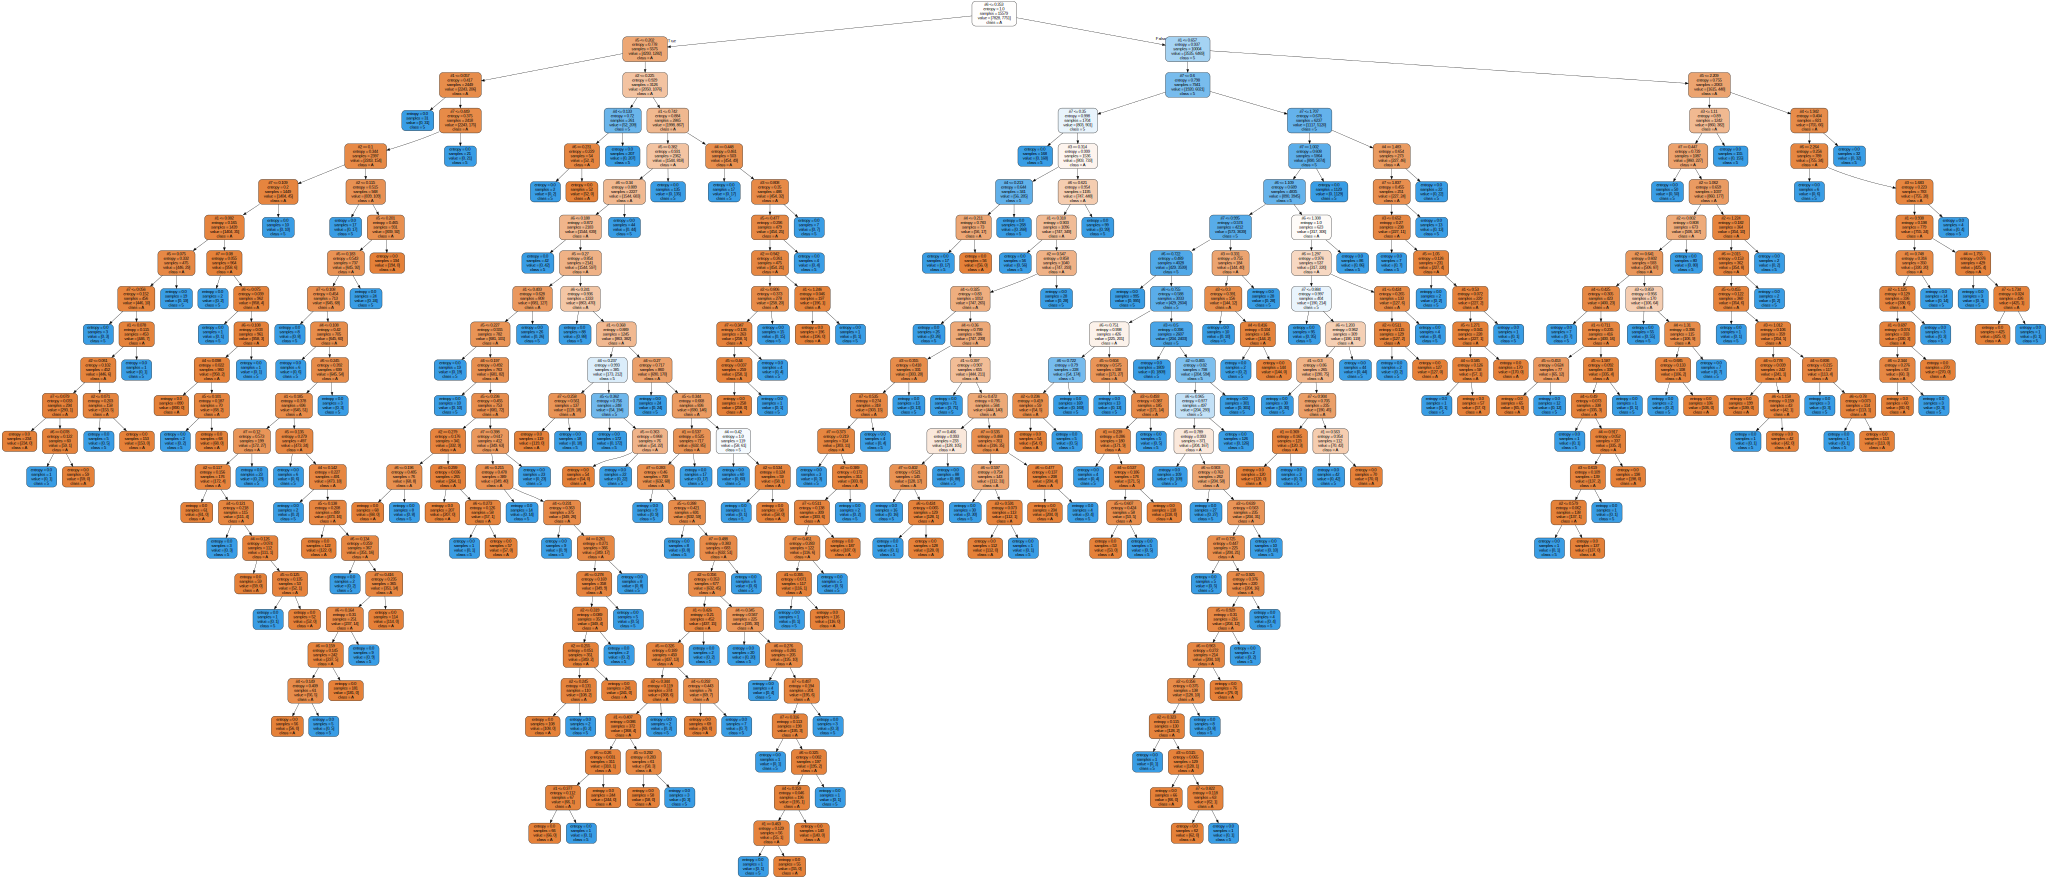

In [15]:
from graphviz import Source    
from sklearn.tree import export_graphviz
import os
IMAGES_PATH='./'

best_clf = DecisionTreeClassifier(criterion="entropy", max_depth=28)
best_clf = best_clf.fit(X_train,y_train)

export_graphviz(
        best_clf,
        out_file=os.path.join(IMAGES_PATH, "tree_deep.dot"),
        feature_names=['#1', '#2', '#3', '#4', '#5', '#6', '#7'],
        class_names=col,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "tree_deep.dot")) 

# Random Forest

In [16]:
def RandomForest():
        
    clf = RandomForestClassifier(n_estimators=100)

    clf = clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=[1, 0]))
    print('  ')

In [17]:
RandomForest()

Accuracy: 0.9983525535420099
[[3366   11]
 [   0 3300]]
  


# Logistic Regression

In [18]:
def Logistic():
    
    clf = LogisticRegression()

    clf = clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=[1, 0]))
    print('  ')

In [19]:
Logistic()

Accuracy: 0.7383555488992062
[[2330 1047]
 [ 700 2600]]
  


# XGBoost

In [20]:
def XGBoost():
    
    best_acc = 0
    for i in range(103,120):
        clf = xgb.XGBClassifier(n_estimators=i, learning_rate=0.1, 
                              objective='binary:logistic', booster='gbtree')

        clf = clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test)

        print(i , "__Accuracy:",metrics.accuracy_score(y_test, y_pred))
        prev_acc = metrics.accuracy_score(y_test, y_pred)

        if prev_acc >= best_acc:
            best_acc = prev_acc
            best_depth = i
            best_clf = clf
            best_y_pred = y_pred

    print('Best Accuracy:', best_acc, ', max_depth:', best_depth)
    print(confusion_matrix(y_test, best_y_pred, labels=[1, 0]))
    print('  ')

In [21]:
XGBoost()

103 __Accuracy: 0.9363486595776547
104 __Accuracy: 0.9360491238580201
105 __Accuracy: 0.9358993559982027
106 __Accuracy: 0.9360491238580201
107 __Accuracy: 0.9360491238580201
108 __Accuracy: 0.9363486595776547
109 __Accuracy: 0.9363486595776547
110 __Accuracy: 0.9364984274374719
111 __Accuracy: 0.9366481952972892
112 __Accuracy: 0.9367979631571065
113 __Accuracy: 0.9369477310169237
114 __Accuracy: 0.9378463381758275
115 __Accuracy: 0.9394937846338176
116 __Accuracy: 0.9393440167740003
117 __Accuracy: 0.9400928560730867
118 __Accuracy: 0.9400928560730867
119 __Accuracy: 0.9400928560730867
Best Accuracy: 0.9400928560730867 , max_depth: 119
[[3004  373]
 [  27 3273]]
  


# SVM

In [22]:
def SVM():
    
    clf = SVC(kernel='linear', C=0.1, random_state=123)

    clf = clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=[1, 0]))
    print('  ')

In [23]:
SVM()

Accuracy: 0.7328141380859667
[[2230 1147]
 [ 637 2663]]
  


In [24]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    # plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

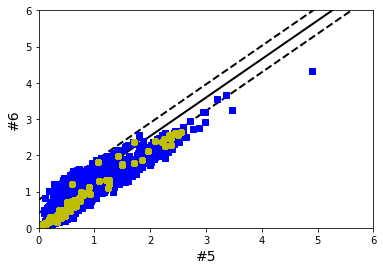

In [25]:
clf = SVC(kernel='linear', C=0.1, random_state=123)
clf = clf.fit(X_train,y_train)

plot_svc_decision_boundary(clf, 0, 6)
plt.plot(X_train.to_numpy()[:,4][y_train==1], X_train.to_numpy()[:,5][y_train==1], "bs")
plt.plot(X_train.to_numpy()[:,4][y_train==0], X_train.to_numpy()[:,5][y_train==0], "yo")
plt.xlabel(X_train.columns[4], fontsize=14)
plt.ylabel(X_train.columns[5], fontsize=14)
plt.axis([0, 6, 0, 6])

plt.show()

# KNN

In [26]:
def KNN():
    
    best_acc = 0
    for i in range(5,10):
        clf = KNeighborsClassifier(n_neighbors = i)

        clf = clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test)

        print(i , "__Accuracy:",metrics.accuracy_score(y_test, y_pred))
        prev_acc = metrics.accuracy_score(y_test, y_pred)

        if prev_acc >= best_acc:
            best_acc = prev_acc
            best_depth = i
            best_clf = clf
            best_y_pred = y_pred

    print('Best Accuracy:', best_acc, ', max_depth:', best_depth)
    print(confusion_matrix(y_test, best_y_pred, labels=[1, 0]))
    print('  ')

In [27]:
KNN()

5 __Accuracy: 0.9814287853826569
6 __Accuracy: 0.9734910888123409
7 __Accuracy: 0.9734910888123409
8 __Accuracy: 0.9680994458589187
9 __Accuracy: 0.9680994458589187
Best Accuracy: 0.9814287853826569 , max_depth: 5
[[3253  124]
 [   0 3300]]
  


# Ensemble

## Voting

In [28]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

In [29]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

In [30]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [31]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, metrics.accuracy_score(y_test, y_pred))

LogisticRegression 0.7383555488992062
RandomForestClassifier 0.9982027856821926
SVC 0.4942339373970346
VotingClassifier 0.976186910289052


## Bagging

In [32]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8193799610603565


In [33]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_tree))

0.9940092856073087
